In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model_config import train_dir_path
import time
import torch
from tensorboardX import SummaryWriter
from data.preprocess_data import TransformedDataset
from network.model_architecture import CNNRegression
from network.train_loop import train_network
from model_config import Hparams_grid, load_state_dict_path, eval_mode, labels_file_path
from utils.logging import pretty_print, generate_log_dir, track_execution_time, get_image_stats
from utils.visualization import plot_and_save_metrics, visualize_predictions
from utils.cleanup import cleanup
from utils.network_utils import load_model, save_model
from utils.network_utils import generate_combinations
from model_config import Hparams

In [2]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
# load the labels from the csv file
labels = pd.read_csv(labels_file_path)
labels

,filename,xRot
0,000000.jpg,336.838887
1,000001.jpg,148.484378
2,000002.jpg,244.821661
3,000003.jpg,222.700630
4,000004.jpg,172.358121
...,...,...
4995,004995.jpg,90.167663
4996,004996.jpg,29.196271
4997,004997.jpg,99.502175
4998,004998.jpg,345.309582


+---------------+---------+
| Description   |   Value |
+===============+=========+
| Mean width    |     512 |
+---------------+---------+
| Std width     |       0 |
+---------------+---------+
| Mean height   |     512 |
+---------------+---------+
| Std height    |       0 |
+---------------+---------+


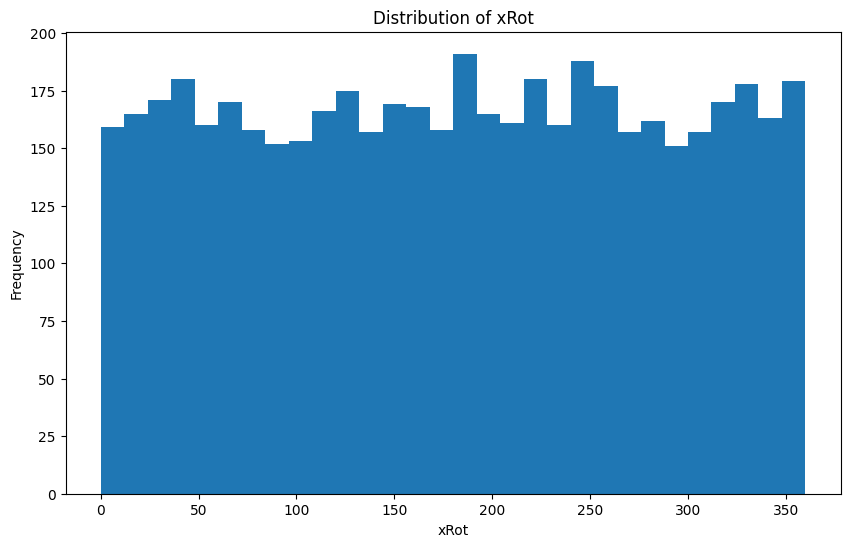

(512.0, 0.0, 512.0, 0.0)

In [4]:
# analyze the data in the training directory
def analyze_data(train_dir_path, labels):
    mean_width, std_width, mean_height, std_height = get_image_stats(train_dir_path)
    pretty_print([
        ["Mean width", mean_width],
        ["Std width", std_width],
        ["Mean height", mean_height],
        ["Std height", std_height]
    ])
    plt.figure(figsize=(10, 6))
    plt.hist(labels['xRot'], bins=30)
    plt.xlabel('xRot')
    plt.ylabel('Frequency')
    plt.title('Distribution of xRot')
    plt.show()
    return mean_width, std_width, mean_height, std_height

analyze_data(train_dir_path, labels)

In [5]:

# Run the program in evaluation mode
def run_eval_mode(untrained_model, load_state_dict_path, val_loader, device):
    """
    Runs the evaluation mode for a trained model.

    Args:
        untrained_model (nn.Module): The untrained model architecture.
        load_state_dict_path (str): The path to the saved state dictionary of the trained model.
        val_loader (DataLoader): The data loader for the validation dataset.
        device (torch.device): The device to run the evaluation on.

    Returns:
        None
    """
    trained_model = load_model(untrained_model, load_state_dict_path)
    trained_model.to(device)
    print("Visualizing predictions for the loaded model...")
    visualize_predictions(trained_model, val_loader)
    cleanup(val_loader, trained_model)

In [6]:
# Run the program in train mode

def run_train_mode(untrained_model, train_loader, val_loader, model_specific_hparams : Hparams, device):
    """
    Runs the training mode for a machine learning model.

    Args:
        untrained_model: The untrained model to be trained.
        train_loader: The data loader for the training dataset.
        val_loader: The data loader for the validation dataset.
        model_specific_hparams: The hyperparameters specific to the model.
        device: The device to be used for training.

    Returns:
        trained_model: The trained model.
    """
    # Start execution logger tracking time
    start_time = time.time()

    # Initialize the summary writer for TensorBoard logging
    tensorboard_base_dir = 'runs'  # Default directory name for TensorBoard logs
    tensorboard_log_dir_path = generate_log_dir(tensorboard_base_dir, model_specific_hparams)
    writer = SummaryWriter(log_dir=tensorboard_log_dir_path)

    # Visualize model architecture in TensorBoard
    images, _ = next(iter(train_loader))  # TensorBoard needs a batch of images to visualize the model without labels
    writer.add_graph(untrained_model, images.to(device))

    # Train the model
    trained_model = train_network(model_params=model_specific_hparams, model=untrained_model, device=device, train_loader=train_loader, val_loader=val_loader, writer=writer)

    # Plot and save metrics after training
    metrics_base_dir = 'metrics'
    metrics_file_path = generate_log_dir(metrics_base_dir, model_specific_hparams) + '.png'
    plot_and_save_metrics(tensorboard_log_dir_path, metrics_file_path)

    # Define model file path
    models_base_dir = 'models'
    save_state_sict_path = generate_log_dir(models_base_dir, model_specific_hparams) + '.pth'

    # Save the model
    save_model(trained_model, save_state_sict_path)

    # Visualize predictions
    print("Visualizing predictions after training...")
    visualize_predictions(trained_model, val_loader)

    # Close the writer
    writer.close()

    # Clean up memory
    cleanup(train_loader, val_loader, trained_model)

    # End tracking time
    end_time = time.time()

    # Track and write execution time to CSV
    track_execution_time(start_time, end_time, save_state_sict_path, Hparams_grid)  # Pass the global Hparams_grid

Running in evaluation mode : True
Training model with hyperparameters grid :
+----------------+----------+
| Description    | Value    |
+================+==========+
| epochs         | [400]    |
+----------------+----------+
| batch_sizes    | [32]     |
+----------------+----------+
| img_pixel_vals | [128]    |
+----------------+----------+
| learn_rates    | [0.001]  |
+----------------+----------+
| activations    | ['relu'] |
+----------------+----------+
Creating a dataset with the following parameters:
+-----------------+---------+
| Description     |   Value |
+=================+=========+
| img_pixel_val   |   128   |
+-----------------+---------+
| batch_size      |    32   |
+-----------------+---------+
| test_split_size |     0.2 |
+-----------------+---------+
Loading model from models/EPOCHS_400_BATCH_SIZES_32_IMG_PIXEL_VALS_128_LEARN_RATES_0.001_ACTIVATIONS_relu_T2024-07-24_08-33-45.pth
Visualizing predictions for the loaded model...
Image shape: torch.Size([1, 128, 1

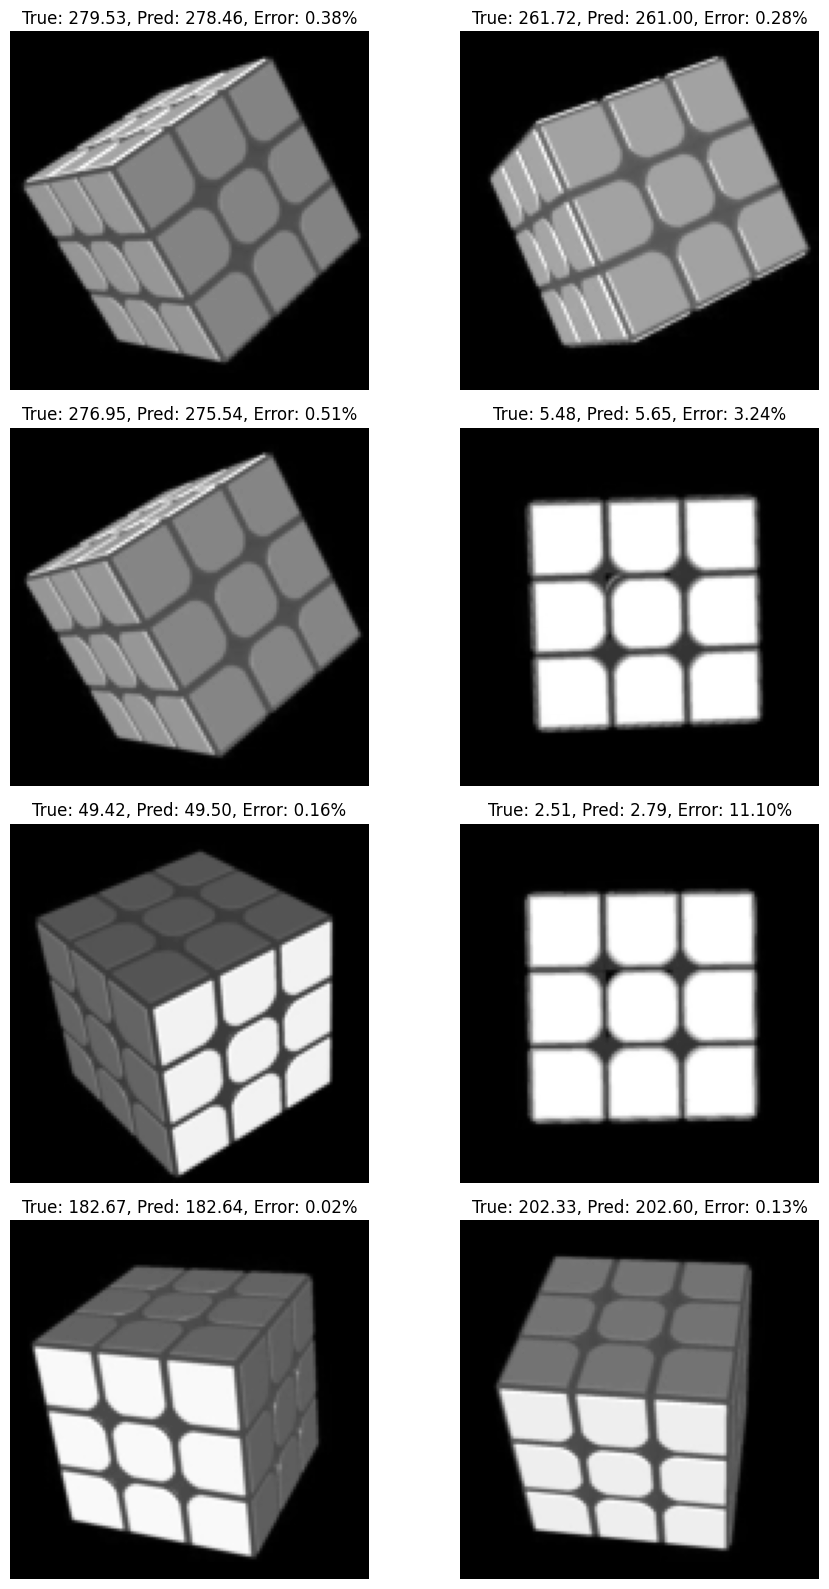

In [7]:
def main(eval_mode : bool):
    """
    The main function of the program.

    Parameters:
    - eval_mode (bool): A boolean indicating whether the program is running in evaluation mode or training mode.

    Returns:
    None
    """
    print("Running in evaluation mode :", eval_mode)
    print("Training model with hyperparameters grid :")
    pretty_print([[key, str(value)] for key, value in Hparams_grid.items()])

    for model_specific_hparams in generate_combinations(Hparams_grid):

        image_size = (1, model_specific_hparams['img_pixel_vals'], model_specific_hparams['img_pixel_vals'])

        # Initialize dataset and dataloaders
        dataset = TransformedDataset(model_specific_hparams=model_specific_hparams)
        train_loader, val_loader = dataset.train_loader, dataset.val_loader

        # Initialize a model instance with random params
        untrained_model = CNNRegression(image_size, model_specific_hparams['activations']).to(device)

        # Visualize initial model with random params for debugging purposes
        # print("Visualizing predictions *BEFORE* training...")
        # visualize_predictions(untrained_model, val_loader)

        if eval_mode:
            run_eval_mode(untrained_model, load_state_dict_path, val_loader, device)
        else :
            run_train_mode(untrained_model,train_loader,val_loader, model_specific_hparams, device)

if __name__ == '__main__':
    main(eval_mode)
